In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker.segment import datasets


In [2]:
# model_type='cyto' or 'nuclei' or 'cyto2'
# model = models.Cellpose(gpu=True, model_type="cyto")
pretrained_model_path = "D:\\xing-vimentin-dic-pipeline\\src\\livecell_dev\\notebooks\\models\\yuzhong_cyto2"
model = models.CellposeModel(pretrained_model=pretrained_model_path, gpu=True)
# list of files
# PUT PATH TO YOUR FILES HERE!
# dir_path = Path(
#     r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\day0_Notreat_Group1_wellA1_RI_MIP_stitched"
# )
# dir_path = Path(
#     r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\restart_day0_Group 1_wellA1_RI_MIP_stitched"
# )
dir_path = Path(
    r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\cxa-data\june_2022_data_8bit_png\restart_day2_Group 1_wellA1_RI_MIP_stitched"
)
# imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="tif")
imgs = segment.datasets.LiveCellImageDataset(dir_path, ext="png")
img_list = sorted(glob.glob(str(dir_path / "*tif")))


pretrained model has incorrect path


576 png img file paths loaded: 


In [3]:
img_list[:4]


[]

In [4]:
def segment_single_image_by_cellpose(image, model, channels=[[0, 0]], diameter=150):
    result_tuple = model.eval([image], diameter=diameter, channels=channels)
    masks = result_tuple[0]
    return masks[0]


def segment_single_images_by_cellpose(images, model, channels=[[0, 0]], diameter=150):
    masks, flows, styles, diams = model.eval(
        images, diameter=diameter, channels=channels
    )
    return masks


Define detectron segmentation

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg


DETECTRON_CFG = gen_cfg(
    model_path=r"D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\train_log\detectron_run3_output\model_final.pth",
    output_dir=r"""D:\xing-vimentin-dic-pipeline\src\livecell_dev\notebooks\train_log\detectron_run3_output""",
)
DETECTRON_PREDICTOR = DefaultPredictor(DETECTRON_CFG)

def segment_by_detectron(img):
    outputs = DETECTRON_PREDICTOR(img)
    return outputs


[09/12 21:40:01 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [6]:
test_img = imgs[0]
test_mask = segment_single_image_by_cellpose(imgs[0], model)


## Create overlay images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


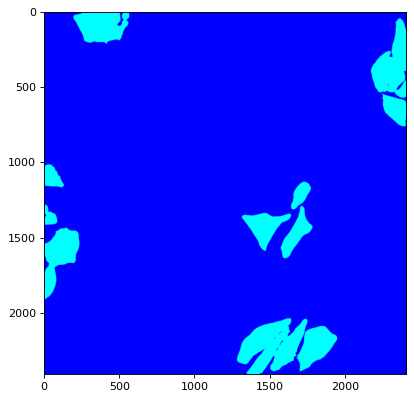

In [7]:
def normalize_img_by_zscore(img: np.array):
    """calculate z score of img and normalize to range [0, 255]

    Parameters
    ----------
    img : np.array
        _description_

    Returns
    -------
    _type_
        _description_
    """
    img = (img - np.mean(img.flatten())) / np.std(img.flatten())
    img = img + abs(np.min(img.flatten()))
    img = img / np.max(img) * 255
    return img


def overlay(image, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=1):
    mask = mask.astype(np.uint8)
    mask[mask > 0] = mask_channel_rgb_val
    image = normalize_img_by_zscore(image).astype(np.uint8)
    image = image * img_channel_rgb_val_factor
    res = np.zeros(list(mask.shape) + [3])
    res[:, :, 2] = image
    res[:, :, 1] = mask
    return res


overlayed_img = overlay(
    test_img, test_mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2
)

figure = plt.figure(figsize=(8, 6), dpi=80)

plt.imshow(overlayed_img)


## Segment all the cells

In [8]:
def convert_detectron_instances_to_label_masks(instances):
    res_mask = np.zeros(instances.shape[1:])
    for idx in range(instances.shape[0]):
        res_mask[instances[idx, :, :]] = idx + 1
    return res_mask


def convert_detectron_instances_to_binary_masks(instances):
    label_mask = convert_detectron_instances_to_label_masks(instances)
    label_mask[label_mask > 0] = 1
    return label_mask

# outputs = segment_by_detectron(normalize_img_by_zscore(imgs[0][:, :, np.newaxis]))["instances"].to("cpu")
# mask = outputs.pred_masks.numpy()
# combine_detectron_instances_masks(outputs.pred_masks.numpy())


## Visualize segmentation by overlay movies

ndigits: 3


  0%|          | 0/576 [00:00<?, ?it/s]c:\Users\dummy\Anaconda3\envs\cv-general\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  3%|▎         | 17/576 [00:38<21:15,  2.28s/it]


KeyboardInterrupt: 

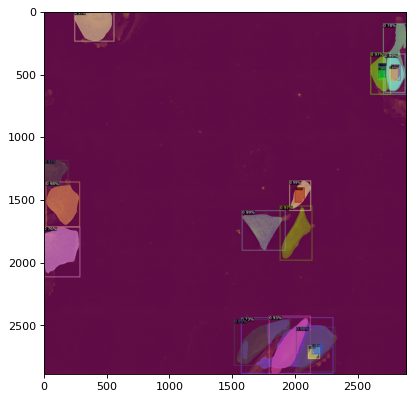

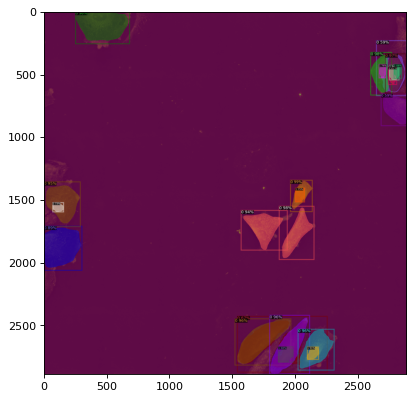

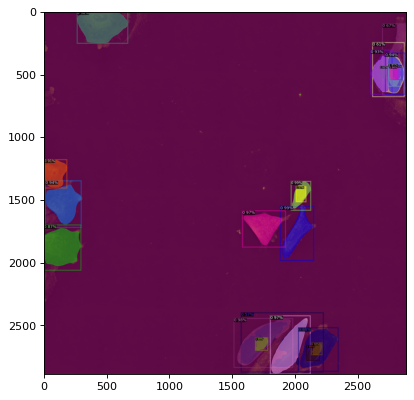

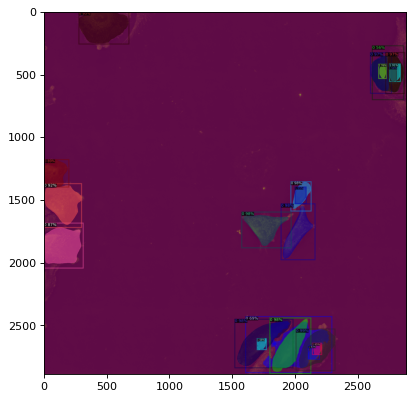

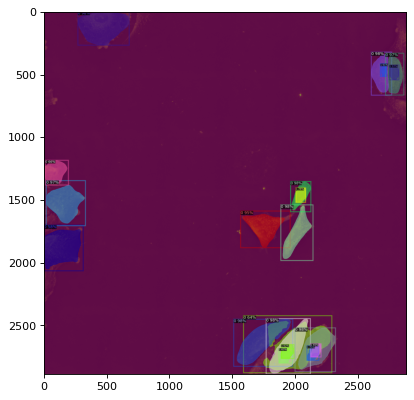

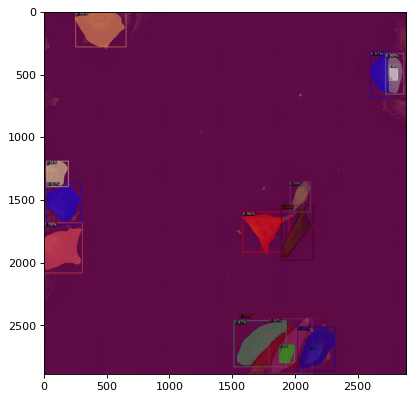

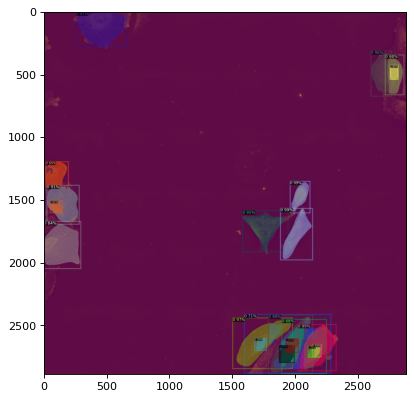

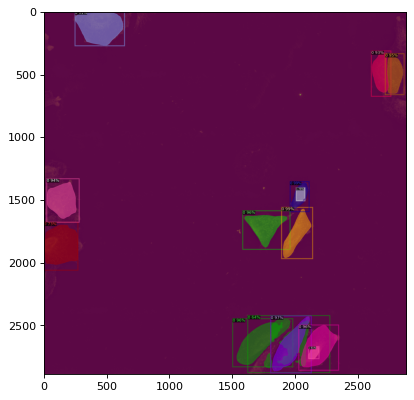

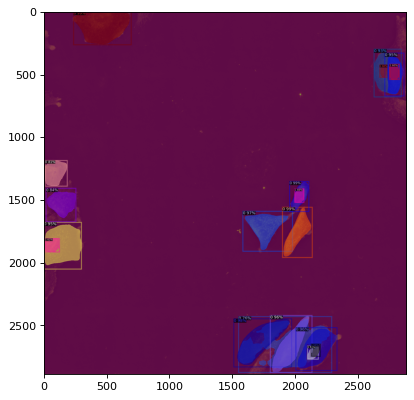

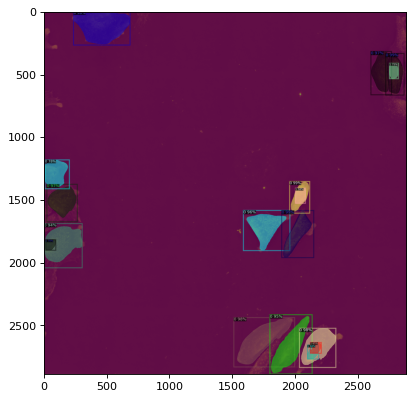

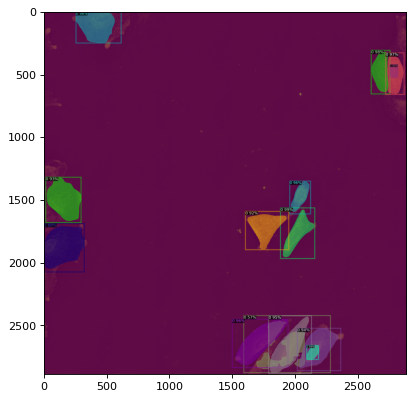

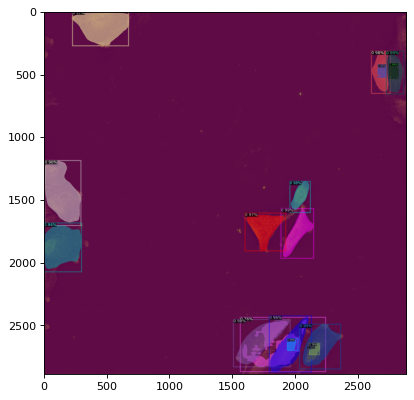

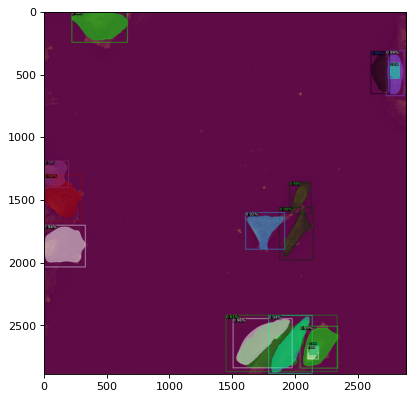

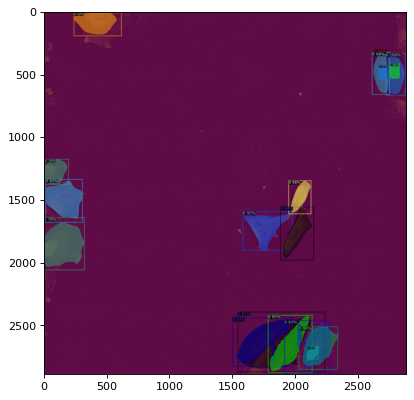

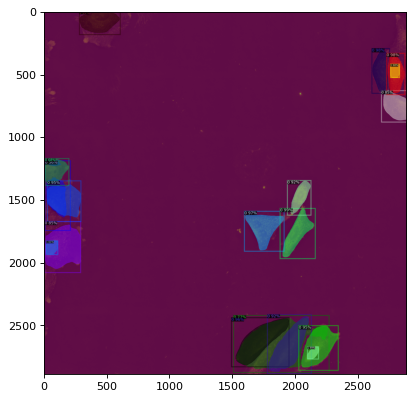

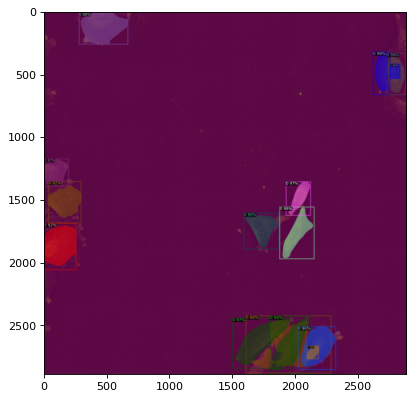

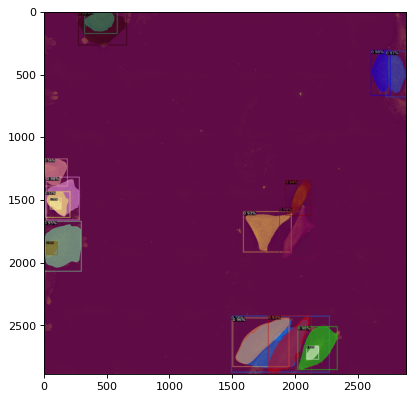

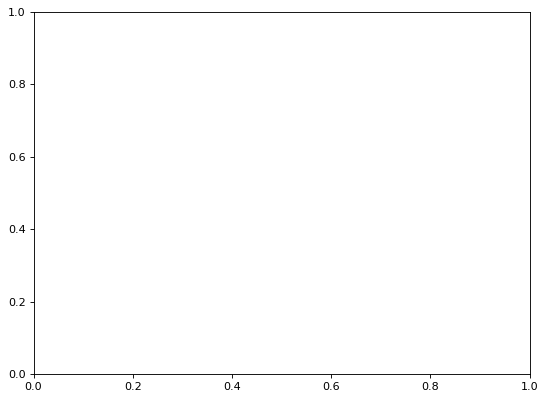

In [9]:
from livecell_tracker.segment.detectron_utils import detectron_visualize_img
def gen_T_filename(frame, ndigits):
    return "T%s.tif" % (str(frame).zfill(ndigits))
ndigits = len(str(len(imgs)))
print("ndigits:", ndigits)

%mkdir seg_tmp
out_dir = Path("./seg_tmp")

def segment_cellpose_wrapper(img):
    return segment_single_image_by_cellpose(img, model, diameter=173)

def segment_detectron_wrapper(img):
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
    results = segment_by_detectron(normalize_img_by_zscore(img))
    instances = results["instances"].to("cpu").pred_masks.numpy()
    mask = convert_detectron_instances_to_binary_masks(instances)
    return mask

def segment_raw_img_by_detectron_wrapper(img, return_detectron_results=False):
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
    results = segment_by_detectron(img)
    instances = results["instances"].to("cpu").pred_masks.numpy()
    mask = convert_detectron_instances_to_binary_masks(instances)
    if return_detectron_results:
        return mask, results
    return mask

segment_func_wrapper = segment_raw_img_by_detectron_wrapper
# segment_func = segment_cellpose_wrapper
# segment_func = segment_detectron_wrapper

# overlay_img_generator = ...
# overlay_img_generator = overlay
# overlay_img_generator = detectron_visualize_img

# def cellpose_segment_imgs(img, out_dir, frame, ndigits):
#     for idx in tqdm(range(len(imgs))):
#         img_path = imgs.get_img_path(idx)
#         img = imgs[idx]
#         file_name = os.path.basename(img_path)
#         output_filename = file_name.split(".")[0] + ".png" # change extension to PNG
#         mask = segment_func_wrapper(img)

#         # convert mask to 8-bit binary mask
#         assert mask.max() < 2**8, "more than 256 instances predicted?"
#         mask = mask.astype(np.uint8)
#         temp_img = Image.fromarray(mask)
#         temp_img.save(out_dir / output_filename)

#         overlay_output_filename = "overlay_" + file_name.split(".")[0] + ".png" # change extension to PNG
#         # overlayed_img = overlay(img, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2)
#         overlayed_img = detectron_visualize_img(img, DETECTRON_CFG, )
#         overlayed_img.save(out_dir / overlay_output_filename)


def detectron_segment_imgs(imgs, out_dir):
    for idx in tqdm(range(len(imgs))):
        img_path = imgs.get_img_path(idx)
        img = imgs[idx]
        file_name = os.path.basename(img_path)
        output_filename = file_name.split(".")[0] + ".png" # change extension to PNG

        ## binary mask
        mask, predictor_results = segment_raw_img_by_detectron_wrapper(img, return_detectron_results=True)
        # convert mask to 8-bit binary mask
        assert mask.max() < 2**8, "more than 256 instances predicted?"
        mask = mask.astype(np.uint8)
        binary_mask_img = Image.fromarray(mask)
        binary_mask_img.save(out_dir / output_filename)
        
        labeled_image_mask = ...

        overlay_output_filename = "overlay_" + file_name.split(".")[0] + ".png" # change extension to PNG
        # overlayed_img = overlay(img, mask, mask_channel_rgb_val=100, img_channel_rgb_val_factor=2)
        overlayed_arr = detectron_visualize_img(img[:, :, np.newaxis], DETECTRON_CFG, predictor_results)
        overlayed_img = Image.fromarray(overlayed_arr)
        overlayed_img.save(out_dir / overlay_output_filename)
        del overlayed_img, overlayed_arr, mask, binary_mask_img, predictor_results

detectron_segment_imgs(imgs, out_dir)

In [10]:
mask, results = segment_raw_img_by_detectron_wrapper(imgs[0], return_detectron_results=True)

In [12]:
results["instances"]

Instances(num_instances=21, image_height=2408, image_width=2408, fields=[pred_boxes: Boxes(tensor([[1629.2192, 1127.2860, 1768.8844, 1323.0769],
        [1313.9688, 1324.6198, 1600.0706, 1587.3673],
        [2261.5498,  285.5565, 2395.1501,  540.5637],
        [1673.1309, 2097.7078, 1931.0616, 2390.3423],
        [  14.4064, 1135.0249,  236.8387, 1431.2102],
        [2291.2805,  367.9258, 2343.0127,  461.3748],
        [1565.8823, 1293.4435, 1777.6277, 1653.3398],
        [2167.2317,  277.8844, 2298.5259,  551.9563],
        [ 203.8056,    3.3517,  464.0971,  200.3067],
        [1262.6936, 2047.1752, 1629.2129, 2350.4124],
        [1493.1272, 2023.7810, 1766.5334, 2408.0000],
        [1752.7297, 2221.5603, 1828.4508, 2305.6145],
        [2303.5391,  357.7634, 2363.0735,  459.3829],
        [   8.4401,  990.4124,  159.7418, 1159.1494],
        [2250.8933,   85.8414, 2408.0000,  551.9700],
        [2220.0071,  349.6713, 2263.9539,  439.0876],
        [   0.0000, 1433.5284,  238.4258, 176